Calculating Bollinger Bands...
Simulating BB Mean Reversion (Window: 3000, Sigma: 2.0)...

 PERFORMANCE REPORT: Bollinger Band Mean Reversion (CAD)

[Text Output]
   Quarter  Gross SR    Net SR  Ann. Vol ($)    Gross CR      Net CR  Gross CumP&L   Net CumP&L  Trades (CAD)  Av. Trades      Stat
0  2023_Q1 -0.213805 -0.275241   2873.326103   -0.314622   -0.403671   -158.990900  -203.990900           9.0    0.138462 -0.000000
1  2023_Q3 -2.172672 -2.247311   3725.611525   -4.089902   -4.218470  -2056.376563 -2126.376563          14.0    0.218750 -2.072625
2  2023_Q4 -1.745853 -1.808185   2633.901433   -2.237519   -2.301651  -1188.443279 -1228.443279           8.0    0.123077 -0.474904
3  2024_Q2  4.025119  3.978228   6005.963078  133.497685  127.950851   6257.899734  6162.899734          19.0    0.292308  6.325322
4  2024_Q4 -1.313894 -1.380026   2451.063608   -2.055025   -2.145375   -845.900818  -885.900818           8.0    0.121212 -0.000000
5  2025_Q1  3.289422  3.237216   5596.008970 

,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades (CAD),Av. Trades,Stat
0,2023_Q1,-0.21,-0.28,"$2,873",-0.31,-0.40,$-159,$-204,9,0.1,-0.0000
1,2023_Q3,-2.17,-2.25,"$3,726",-4.09,-4.22,"$-2,056","$-2,126",14,0.2,-2.0726
2,2023_Q4,-1.75,-1.81,"$2,634",-2.24,-2.30,"$-1,188","$-1,228",8,0.1,-0.4749
3,2024_Q2,4.03,3.98,"$6,006",133.50,127.95,"$6,258","$6,163",19,0.3,6.3253
4,2024_Q4,-1.31,-1.38,"$2,451",-2.06,-2.15,$-846,$-886,8,0.1,-0.0000
5,2025_Q1,3.29,3.24,"$5,596",18.95,18.34,"$4,706","$4,601",21,0.3,4.1776
6,2025_Q2,1.82,1.78,"$5,211",6.24,6.02,"$2,454","$2,389",13,0.2,1.1131
7,TOTAL,-,-,"$4,330",-,-,"$9,168","$8,708",92,0.2,9.0685



 TOTAL RANKING SCORE: 9.0685


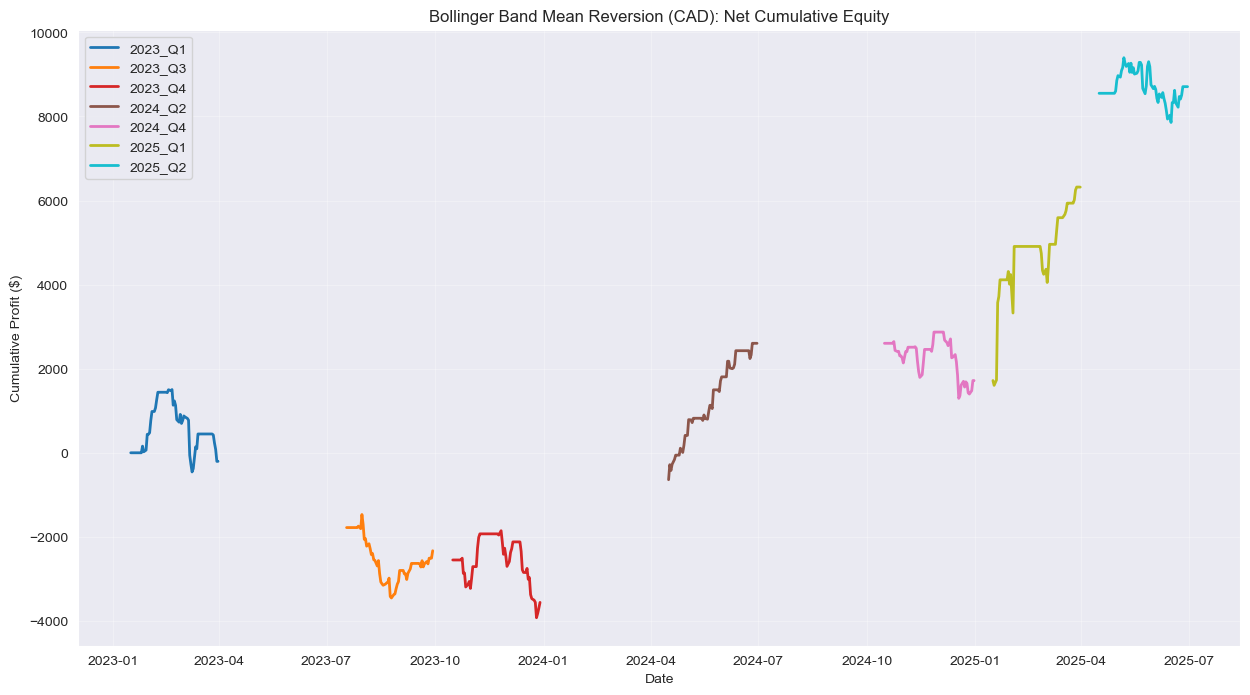

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

# Filter warnings for cleaner output
warnings.filterwarnings('ignore')


# ==========================================
# 1. Configuration
# ==========================================
class Config:
    # File Path (Same as reference)
    FILE_PATH = '../preprocess/df_g2_processed.pkl'

    # Asset changed to CAD as requested
    ASSETS = ['CAD']

    # Contract Specifications
    # Assuming Standard Lot for CAD (100,000 units).
    # 1 pip (0.0001) move = $10. Cost set conservatively at $5 per trade.
    SPECS = {
        'CAD': {'point_val': 100000.0, 'cost': 5.0}
    }

    # --- Strategy Parameters (Bollinger Bands Mean Reversion) ---

    # Bollinger Band Settings
    BB_WINDOW = 3000  # Moving Average Window (20 is standard)
    BB_SIGMA = 2.0  # Standard Deviation Multiplier (+/- 2sigma)

    ANNUALIZATION = 252


# ==========================================
# 2. Data Preparation (Bollinger Bands)
# ==========================================
def prepare_bb_data(file_path, cfg):
    """
    Loads data and calculates Bollinger Bands for CAD.
    """
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print("Error: File not found.")
        return None

    req_cols = cfg.ASSETS + ['Quarter_ID']
    if 'Is_In_Sample' in df.columns:
        req_cols.append('Is_In_Sample')

    # Ensure CAD column exists
    if 'CAD' not in df.columns:
        print("Error: 'CAD' column not found in the dataframe.")
        return None

    data = df[req_cols].copy()

    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print("Calculating Bollinger Bands...")

    def calc_bb_metrics(group):
        price = group['CAD']

        # 1. Calculate Moving Average (Center Line)
        ma = price.rolling(window=cfg.BB_WINDOW).mean()

        # 2. Calculate Standard Deviation
        std = price.rolling(window=cfg.BB_WINDOW).std()

        # 3. Calculate Bands
        upper = ma + (cfg.BB_SIGMA * std)
        lower = ma - (cfg.BB_SIGMA * std)

        group['MA'] = ma
        group['Upper'] = upper
        group['Lower'] = lower

        return group

    # Apply per Quarter to maintain independent testing periods
    data = data.groupby('Quarter_ID', group_keys=False).apply(calc_bb_metrics)

    # Drop initial NaNs from rolling window
    data.dropna(subset=['MA', 'Upper', 'Lower'], inplace=True)

    return data


# ==========================================
# 3. Strategy Logic (Signal Execution)
# ==========================================
def run_bb_strategy(df, cfg):
    """
    Executes trades based on Bollinger Band Mean Reversion.
    Entry Short: Price touches +2 sigma
    Entry Long:  Price touches -2 sigma
    Exit:        Price touches MA
    """
    data = df.copy()

    price = data['CAD'].values
    upper = data['Upper'].values
    lower = data['Lower'].values
    ma = data['MA'].values
    in_sample = data['Is_In_Sample'].values

    pos_cad = np.zeros(len(data), dtype=int)
    curr_pos = 0

    print(f"Simulating BB Mean Reversion (Window: {cfg.BB_WINDOW}, Sigma: {cfg.BB_SIGMA})...")

    for i in range(len(data)):
        if not in_sample[i]:
            curr_pos = 0
            pos_cad[i] = 0
            continue

        p = price[i]
        u = upper[i]
        l = lower[i]
        m = ma[i]

        # --- Trading Logic ---

        # 1. Check Entry
        if curr_pos == 0:
            if p >= u:
                # Price touched Upper Band -> Short
                curr_pos = -1
            elif p <= l:
                # Price touched Lower Band -> Long
                curr_pos = 1

        # 2. Check Exit (Mean Reversion to MA)
        elif curr_pos == 1:  # Currently Long
            # Exit if price recovers to MA (or goes higher)
            if p >= m:
                curr_pos = 0

        elif curr_pos == -1:  # Currently Short
            # Exit if price drops to MA (or goes lower)
            if p <= m:
                curr_pos = 0

        pos_cad[i] = curr_pos

    # Shift positions to align with next bar's return (Strategy execution delay)
    data['Pos_CAD'] = pd.Series(pos_cad, index=data.index).shift(1).fillna(0)

    return data


# ==========================================
# 4. P&L Calculation & Aggregation
# ==========================================
def calculate_metrics(data, cfg):
    """
    Calculates P&L and aggregates to Daily.
    """
    df = data.copy()

    df['dPrice_CAD'] = df['CAD'].diff()

    # Gross PnL
    df['Gross_PnL_Total'] = df['Pos_CAD'] * df['dPrice_CAD'] * cfg.SPECS['CAD']['point_val']

    # Transaction Costs
    df['Trades_CAD'] = df['Pos_CAD'].diff().abs().fillna(0)
    df['Cost_Total'] = df['Trades_CAD'] * cfg.SPECS['CAD']['cost']

    # Net PnL
    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_CAD']

    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_CAD': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats


# ==========================================
# 5. Performance Stats & Reporting
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    """
    Generates summary statistics table using the same ranking logic.
    """
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()

        if len(d_q) == 0:
            continue

        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if std_g != 0 else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if std_n != 0 else 0

        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION)

        years = len(d_q) / cfg.ANNUALIZATION

        equity_g = d_q['Gross_PnL_Total'].cumsum()
        max_dd_g = (equity_g.cummax() - equity_g).max()
        gross_cr = (gross_cum_pnl / years / max_dd_g) if (max_dd_g > 0) else 0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        net_cr = (net_cum_pnl / years / max_dd_n) if (max_dd_n > 0) else 0

        trades_cad = d_q['Trades_CAD'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        # Summary Statistic (Ranking Score)
        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (CAD)': trades_cad,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    return pd.DataFrame(stats_list)


def plot_equity_curve(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return

    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

    plt.figure(figsize=(15, 8))

    daily_stats['Global_Equity'] = daily_stats['Net_PnL_Total'].cumsum()

    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q]
        plt.plot(d_q.index, d_q['Global_Equity'], label=q, color=colors[i], lw=2)

    plt.title('Bollinger Band Mean Reversion (CAD): Net Cumulative Equity')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# ==========================================
# 6. Main Execution
# ==========================================
if __name__ == "__main__":
    cfg = Config()

    # 1. Prepare Data (BB Calculation)
    df_prep = prepare_bb_data(cfg.FILE_PATH, cfg)

    if df_prep is not None:
        # 2. Run Strategy
        df_res = run_bb_strategy(df_prep, cfg)

        # 3. Calculate Metrics
        daily_data = calculate_metrics(df_res, cfg)

        # 4. Generate Report
        stats_table = generate_quarterly_stats(daily_data, cfg)

        # --- Display Table ---
        print("\n" + "=" * 80)
        print(" PERFORMANCE REPORT: Bollinger Band Mean Reversion (CAD)")
        print("=" * 80)

        if not stats_table.empty:
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_cad = stats_table['Trades (CAD)'].sum()

            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION)

            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (CAD)': total_trades_cad,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)

            format_dict = {
                'Gross SR': '{:.2f}', 'Net SR': '{:.2f}',
                'Ann. Vol ($)': '${:,.0f}',
                'Gross CR': '{:.2f}', 'Net CR': '{:.2f}',
                'Gross CumP&L': '${:,.0f}', 'Net CumP&L': '${:,.0f}',
                'Trades (CAD)': '{:,.0f}',
                'Av. Trades': '{:.1f}',
                'Stat': '{:.4f}'
            }

            print("\n[Text Output]")
            print(display_df.to_string(
                formatters={k: v.format for k, v in format_dict.items() if isinstance(v, str) == False}, na_rep="-"))

            print("\n[Table Output]")
            try:
                # Highlight last row (Total) and format background gradient for 'Stat'
                subset_stat = pd.IndexSlice[0:len(display_df) - 2, ['Stat']]
                styled_df = display_df.style.format(format_dict, na_rep="-") \
                    .background_gradient(subset=subset_stat, cmap='RdYlGn') \
                    .apply(lambda x: ['font-weight: bold' if x.name == len(display_df) - 1 else '' for i in x], axis=1)
                display(styled_df)
            except:
                display(display_df)

            print(f"\n{'=' * 40}")
            print(f" TOTAL RANKING SCORE: {total_score:.4f}")
            print(f"{'=' * 40}")
        else:
            print("⚠️ No statistics generated.")

        # 5. Plot
        plot_equity_curve(daily_data)